In [1]:
import dgl
import torch
from tqdm import tqdm
from time import process_time
import os
import numpy as np
import itertools
from torch.sparse import *
import collections
os.environ['DGLBACKEND'] = 'pytorch'

from scipy import stats

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ogb.nodeproppred import DglNodePropPredDataset, Evaluator

import matplotlib.pyplot as plt
import json
import pickle

This builds the 1-skeleton of a standard simplex

In [2]:
class SimplexCreator():
    
    
    """Create standard simplex"""
    
    
    def __init__(self, dimension):
        self.input_dimension = dimension
        self.src=list()
        self.dst=list()
        for i in range(self.input_dimension+1):
            for j in range(self.input_dimension+1):
                if (i < j):
                    self.src = self.src + [i]
                    self.dst = self.dst + [j]

The preprocessing step -- this is where we find pseudotop vertices for a given graph.

In [2]:
def find_common_tensors(tensor_A, tensor_B, batch_size=1000):
    
    
    """This finds common edges from two matrices -- effectively computing
    the Hadamard product of two matrices with binary entries
    However, this process takes way too much space, so won't be used."""
    
    
    common_pairs_list = []
    print("Performing batches of edge comparison")
    for i in tqdm(range(0, tensor_A.size(0), batch_size), position=0, leave=False):
        batch_A = tensor_A[i:i+batch_size]
        equal_pairs = torch.all(batch_A[:, None, :] == tensor_B[None, :, :], dim=2)
        common_pair_indices = torch.nonzero(equal_pairs, as_tuple=False)
        common_pairs_list.append(tensor_A[common_pair_indices[:, 0]])
    
    return torch.cat(common_pairs_list)

class PseudoTV():
    
    
    src=list()
    dst=list()
    empty_graph = dgl.heterograph({('node', 'to', 'node'): (src, dst)})
    dimension = int

    assert isinstance(empty_graph, dgl.DGLHeteroGraph), \
        'Keyword argument \"graph\" of AdjGraph\'s init methodmust be a dgl.DGLHeteroGraph.'

    def __init__(
        self, file_path, graph=empty_graph,dimension=dimension):
        self.seed_graph = graph
        self.srcs_and_dsts = self.seed_graph.edges()   
        
        """Create dictionary with dimension (keys) and place list of nodes with 
        all possible top dimensions (values)"""
        self.top_vertices_dictionary = collections.defaultdict(list)
        self.top_vertices_dictionary[0]=[int(x) for x in self.seed_graph.nodes()]
        self.top_vertices_dictionary[1]=[int(x) for x in torch.unique(self.srcs_and_dsts[1])]
        """ This dict has keys = dimensions d and values = dictionary. This 
        subdictionary has keys = nodes and values =
        vertices that make the node a top-vertex of dimension d"""

        print("Finished adding 0-top vertices and 1-top vertices in main dictionary")
        
        """compute all in_degrees. These are needed for the algorithm later on 
        when the loop runs"""
        self.in_degrees = self.seed_graph.in_degrees()
        self.out_degrees = self.seed_graph.out_degrees()
        self.dimension = dimension
        self.maximum_dimension = int(torch.max(self.in_degrees))
        
        self.file_path=file_path
        
        """Create dictionary with dimension (keys) and list of nodes with maximum
        dimension corresponding to key (values)"""
        self.pseudo_top_vertices_dict = collections.defaultdict(list)
        for v in self.seed_graph.nodes():
            """Add all zero-dimension vertices, and for now keep rest as 1-dimension vertices.
            The vertices moved to different keys as more simplices are identified"""
            if self.in_degrees[v] == 0:
                self.pseudo_top_vertices_dict[0] = self.pseudo_top_vertices_dict[0] + [int(v)]
            else:
                self.pseudo_top_vertices_dict[1] = self.pseudo_top_vertices_dict[1] + [int(v)]
                
        print("Finished adding 0-pseudo top vertices and 1-pseudo top vertices")
        
        """Create empty dictionary as above, but this time will have sets 
        (value) for each dimension (key)"""        
        self.pseudo_top_vertices_dict_of_sets = dict()
        
        """Same values as above, but keys are addresses of the sets""" 
        self._sets = dict()
        
        """ Creates dictionary from above sets that has 
        representatives (keys) and sets (values)"""
        self._partition = dict()

        """ Needed for refinement. Finds vertices in same class for 
        each iteration of refinement"""
        self.refined_partition = dict()
        
        """ Number of refinements done after TV identification
        for each vertex. Needed to find final partition index"""
        self.partition_number = 0
        
        """ Dictionary with keys = nodes as values = partition 
        index of that node. Currently at zero, since
        no refinement is done, yet! The values for each key 
        is supposed to be the partition_number"""
        self.partition_index = {int_node: 0 for int_node in self.top_vertices_dictionary[0]}
        
        """Create dictionary with keys = nodes and values = 
        one-hot tensor of top-vertex and parition index,
        both concatenated"""
        self.partition_indices_and_one_hot_tv = {int_node: [] for int_node in self.top_vertices_dictionary[0]}
        
        """ Create dictionary with keys = nodes and values = 
        one hot encoding of pseudo top dimension. That is
        ith index 1 if top maximum dimension is equal to 
        index and zero otherwise """
        self.one_hot_dict = collections.defaultdict(list)

        """ Create dictionary with keys = nodes. The values 
        for the dictionary 
        are tensors which are multi hot encoding with ith 
        index 1 for i-top dimension and zero otherwise """
        self.multi_hot_tv_dict = collections.defaultdict(list)
        
        """ Create dictionary with keys = nodes and values = 
        one hot encoding with ith index 1 if vertex is refined i
        times and zero otherwise. This is an index of number of 
        times a vertex has been partitioned. """
        self.partition_times_hot_dict = collections.defaultdict(list)
        
        """ Create dictionary with keys = nodes and values = 
        one hot encoding with ith index 1 if vertex is in the
        ith partition and zero otherwise. This captures the 
        number of partitions after refinement. """
        self.partitioned_tv = collections.defaultdict(list)
        
        """ Create a dictionary of vectors R(v) for each vertex v. 
        This gets updated at each refinement process. 
        The values are stored since then the algorithm wouldn't 
        have to create the vector each time its needed"""
        self.refinement_vectors_dict = collections.defaultdict(list)
        
        """ Boolean expression to see if refinement needs to proceed"""
        self.partition_proceeds = True
        
    def kill_diag_make_binary(self,matrix):
        
        
        diagonal_mask = (matrix._indices()[0] == matrix._indices()[1])
        off_diagonal_mask = ~diagonal_mask
        #set all zero values to one where the edge is not a loop
        matrix._values()[off_diagonal_mask] = 1.0
        #create a new sparse matrix with diagonal elements killed off
        new_indices = matrix._indices()[:, off_diagonal_mask]
        #only use original nonzero values (which were later changed to 1)
        new_values = matrix._values()[off_diagonal_mask]
        new_size = matrix.size()
        return torch.sparse_coo_tensor(indices=new_indices, values=new_values, size=new_size)
    
    def hadamard_prod(self, matrix1, matrix2):
        
        
        false_hadamard_product = matrix1 * matrix2
        false_hadamard_product = false_hadamard_product.coalesce()
        non_zero_mask = false_hadamard_product._values().nonzero().squeeze()
        non_zero_values = false_hadamard_product._values()[non_zero_mask]
        non_zero_indices = false_hadamard_product.indices()[:, non_zero_mask]
        hadamard_product = torch.sparse_coo_tensor(indices=non_zero_indices,
                                                   values=non_zero_values,
                                                   size=false_hadamard_product.size())
        """Alternate approach, and the correct one without bugs.
        Isn't used."""
        #edges_1 = matrix1._indices().transpose(0, 1)
        #edges_2 = matrix2._indices().transpose(0, 1)
        #edges = find_common_tensors(edges_1, edges_2)
        #adj_size =  len(self.seed_graph.nodes())
        #indices = edges.t().long()
        #values = torch.ones(edges.shape[0], dtype=torch.int64)
        #hadamard_product = torch.sparse_coo_tensor(indices=indices, 
                                                   #values=values, size=torch.Size([adj_size, adj_size]))
        return hadamard_product

        
    def __len__(self):
        
        
        """Return the size of the partition."""
        
        
        return len(self._sets)

    def out_nodes_as_int(self, vertex):
        
        
        """convert successors to a list with integer node values"""
        
        
        neighbors = [int(v) for v in list(self.seed_graph.successors(vertex))]
        if int(vertex) in neighbors:
            neighbors.remove(int(vertex))
        return neighbors

    def in_nodes_as_int(self, vertex):
        
        
        """convert predecessors to a list with integer node values"""
        
        
        neighbors = [int(v) for v in list(self.seed_graph.predecessors(vertex))]
        if int(vertex) in neighbors:
            neighbors.remove(int(vertex))
        return neighbors       
    
    def inductive_connecting(self):
        
        
        #Case for k=2 doesn't need to search for intersections:
        print("Computing matrices of dimension 2")
        no_diag_binary = torch.sparse.mm(self.seed_graph.adj_external(),
                                         self.seed_graph.adj_external())
        no_diag_binary = self.kill_diag_make_binary(no_diag_binary) 
        self.hadamard_product_next = self.hadamard_prod(
            self.seed_graph.adj_external(),no_diag_binary)
        print("Adding 2-vertices to the dictionary")
        row_indices_analyzed_node, col_indices_analyzed_node = self.hadamard_product_next._indices()
        for vertex in col_indices_analyzed_node.unique():
            self.top_vertices_dictionary[2] = self.top_vertices_dictionary[2] + [int(vertex)]
            self.pseudo_top_vertices_dict[2] = self.pseudo_top_vertices_dict[2] + [int(vertex)]
            if vertex in self.pseudo_top_vertices_dict[1]:
                self.pseudo_top_vertices_dict[1].remove(int(vertex))
        print("Finished adding vertices of dimension 2")
        #remove these variables from memory
        row_indices_analyzed_node = None
        col_indices_analyzed_node = None
        
        for k in tqdm(range(3,self.dimension+1), position=0, leave=False):
            no_diag_binary = torch.sparse.mm(self.seed_graph.adj_external(),no_diag_binary)
            no_diag_binary = self.kill_diag_make_binary(no_diag_binary)
            #compute A⚬A^2⚬..⚬A^k where ⚬ denotes Hadamard product
            self.hadamard_product_prev  = self.hadamard_product_next.clone().detach()
            self.hadamard_product_next = self.hadamard_prod(
                self.hadamard_product_prev,no_diag_binary)
            print("Finished computing matrices for dim",k)
            
            for v in tqdm(self.seed_graph.nodes(), position=0, leave=False):
                if v in self.top_vertices_dictionary[k-1]:
                    if self.in_degrees[v] < k:
                        continue
                    else:
                        current_in_neighbors_of_node_analyzed = self.in_nodes_as_int(v)
                        for u in tqdm(self.top_vertices_dictionary[k-1], position=0, leave=False):
                            if u == v:
                                continue
                            if u not in current_in_neighbors_of_node_analyzed:
                                continue
                            else:
                                A = self.hadamard_product_prev
                                B = self.hadamard_product_next
                                A = A.coalesce()
                                B = B.coalesce()
                                A_row, A_col = A.indices()
                                B_row, B_col = B.indices()
                                if len(B_col) == 0:
                                    print("We have reached maximum dimension, and that is",k-1)
                                    self.maximum_dimension = k-1
                                    self.top_vertices_dictionary.pop(k, None)
                                    return
                                A_u_rows = A_row[torch.where(A_col.eq(u))]
                                B_v_rows = B_row[torch.where(B_col.eq(v))]
                                common_rows = np.intersect1d(A_u_rows, B_v_rows)
                                #these are all the vertices for which there is a path with unique vertices
                                #of length 1, length 2, ..., length k-1 to both u and v
                                intersection_criterion = False
                                for i in common_rows:
                                    intersection = set(self.out_nodes_as_int(i)).intersection(
                                        set(self.in_nodes_as_int(u))).intersection(set(current_in_neighbors_of_node_analyzed))
                                    if len(intersection) > k-3:
                                        intersection_criterion = True
                                        break
                                if not(intersection_criterion):
                                    continue
                                else:
                                    self.top_vertices_dictionary[k] = self.top_vertices_dictionary[k] + [int(v)]
                                    self.pseudo_top_vertices_dict[k] = self.pseudo_top_vertices_dict[k] + [int(v)]
                                    if v in self.pseudo_top_vertices_dict[k-1]:
                                        self.pseudo_top_vertices_dict[k-1].remove(int(v))
                                        """a new top vertex v is found, so we can move out of the neighborhood of v"""
                                    break
                        
            if len(self.top_vertices_dictionary[k]) == 0:
                print("We have reached maximum dimension, and that is",k-1)
                self.maximum_dimension = k-1
                self.dimension = k-1
                self.top_vertices_dictionary.pop(k, None)
                break
        print("Now creating other initial dictionaries")
        self.pseudo_top_vertices_dict_of_sets = {key:set(self.pseudo_top_vertices_dict[key]) 
                                                for key in range(0,self.dimension+1)}
        
        self._sets = {id(self.pseudo_top_vertices_dict_of_sets[key]):self.pseudo_top_vertices_dict_of_sets[key]
                                 for key in self.pseudo_top_vertices_dict_of_sets.keys()}
        self._partition = {x:self.pseudo_top_vertices_dict_of_sets[key] 
                              for key in self.pseudo_top_vertices_dict_of_sets.keys() 
                           for x in self.pseudo_top_vertices_dict_of_sets[key]}
        print("Finished creating initial partition")
        print("Serializing dictionaries..")
        data_to_save = {"pseudo_top_vertices_dict": {str(key): value 
                                                     for key, value in self.pseudo_top_vertices_dict.items()}}
        data_to_save = {
            "pseudo_top_vertices_dict": {str(key): value 
                               for key, value in self.pseudo_top_vertices_dict.items()},
            "top_vertices_dict": {str(key): value 
                               for key, value in self.top_vertices_dictionary.items()}}
        
        
        with open('pseudo_tv.json', "w") as file:
            json.dump(data_to_save, file)
        print("Dictionary of pseudo top vertices saved as a JSON file")
    
    def partition_vector(self,vertex):
        
        
        """ Create vector R(v) for vertex v """ 
        
        
        vector = [self._partition[vertex]]
        for v in torch.sort(self.seed_graph.predecessors(vertex))[0]:
            """ The representatives have to be sorted for a meaningful comparison of vectors """
            if torch.eq(v,vertex):
                pass
            else:
                vector = vector + [self._partition[int(v)]]
        return vector
        
    def refine(self):
        
        
        """Original idea for refinement algorithm by David Eppstein. 
        Refine each set A in the partition to the two sets
        A & S, A - S.  Also produces output (A & S, A - S)
        for each changed set.  Within each pair, A & S will be
        a newly created set, while A - S will be a modified
        version of an existing set in the partition.
        
        Hit here is a dictionary with keys = addresses for 
        original partitions and values = vertices with common
        partition vector"""
        
        
        hit = self.refined_partition
        output = list()
        for A,AS in hit.items():
            A = self._sets[A]
            """Check if new partition is not the same as the old partition"""
            if AS != A:
                self._sets[id(AS)] = AS
                """ This loop finds elements that are not part of previous partition"""
                for x in AS:
                    self._partition[x] = AS
                """The elements that were not part of the partition are now A"""
                A -= AS
                output = output + [set.union(A,AS)]
        """ output here keeps track of those partitions that have been broken down"""
        refined_vertices = set().union(*output)
        """The partitioning process above, once done, should then 
        increase the partition_number, if the above
        does indeed count as another genuine refinement. If it 
        does not, then the number of refined_vertices
        is zero, and hence should not increase partition number"""
        if len(refined_vertices) == 0:
            self.partition_proceeds = False
            return
        else:
            """If there is a refinement that takes place, then we 
            increase the partition number and attach
            this as the partition index for each vertex in the 
            partition_index dictionary"""
            self.partition_number = self.partition_number+1
            for v in refined_vertices:
                self.partition_index[v] = self.partition_number

    def refinement(self):
        
        
        """Keep on refining the partitions until the partition stabilizes"""
        
        
        while self.partition_proceeds:
            print("Refining..")
            """finds vertices u and v such that R(u) = R(v) and make refined partitions here"""
            common_vertices = dict()
            for node in tqdm(self.seed_graph.nodes(), position=0, leave=False):
                self.refinement_vectors_dict[int(node)] = self.partition_vector(int(node))
            print("Finished creating list of partition vectors for", 
                  "partition iteration number",self.partition_number)
            print("Finding vertices with common partition vectors..")
            """This step could be modified for optimization. It needlessly also checks
            for partion vectors of vertices that have not been partitioned the first time"""
            for v,u in tqdm(itertools.combinations(
                self.seed_graph.nodes(),2), position=0, leave=False):
                if self.refinement_vectors_dict[int(v)] == self.refinement_vectors_dict[int(u)]:
                    Au = self._partition[int(u)]
                    common_vertices.setdefault(id(Au),set()).update([int(u),int(v)])
            self.refined_partition=common_vertices  
            self.refine()
        print("Refinement process finished")

    def add_vertex_features(self):
        
        
        """First, we start with refinement until the partition stabilizes"""
        
        
        sets_for_partition_as_list = list(self._sets.values())
        print("Adding in node features..")
        for node in tqdm(self.seed_graph.nodes(), position=0, leave=False):
            """ Fills in the following dictionaries
            1) multi_hot_tv_dict
            2) one_hot_dict
            3) partition_indices_and_one_hot_tv
            4) partition_times_hot_dict
            5) partitioned_tv
            by filling in each key (node)"""
            pihvector = [0] * (self.partition_number+1)
            mhvector = [0] * (self.dimension+1)
            ohvector = [0] * (self.dimension+1)
            ptvvector = [0] * (len(self._sets))
            node = int(node)
            for dim in range(0,self.dimension+1):
                if node in self.top_vertices_dictionary[dim]:
                    mhvector[dim] = 1
                if node in self.pseudo_top_vertices_dict[dim]:
                    ohvector[dim] = 1
            pihvector[self.partition_index[node]] = 1
            self.multi_hot_tv_dict[node] = mhvector
            self.one_hot_dict[node] = ohvector
            self.partition_times_hot_dict[node] = pihvector
            temp_vector = self.one_hot_dict[node] + self.partition_times_hot_dict[node]
            self.partition_indices_and_one_hot_tv[node] = temp_vector
            index = sets_for_partition_as_list.index(self._partition[node])
            ptvvector[index] = 1
            self.partitioned_tv[node] = ptvvector
        print("Vertex features added!")
          
    def save_dicts(self):
        
        
        print("Serializing dictionaries for vertex features..")
        data_to_save = {
            "partitioned_tv": {str(key): value 
                               for key, value in self.partitioned_tv.items()},
            "partition_indices_and_one_hot_tv": {str(key): value 
                                                 for key, value in self.partition_indices_and_one_hot_tv.items()},
            "multi_hot_tv_dict": {str(key): value 
                                  for key, value in self.multi_hot_tv_dict.items()},
            "partition_times_hot_dict" : {str(key): value 
                                          for key, value in self.partition_times_hot_dict.items()}
        }
        
        with open(self.file_path, "w") as file:
            json.dump(data_to_save, file)
        print("Dictionaries saved as a JSON file")
        
    def load_dicts(self):
        
        
        with open(self.file_path, "r") as file:
            loaded_data = json.load(file)
        
        self.partitioned_tv = {int(key): torch.tensor(value)
                               for key, value in loaded_data["partitioned_tv"].items()}
        
        self.partition_indices_and_one_hot_tv = {int(key): torch.tensor(value)
                                                 for key, value in loaded_data["partition_indices_and_one_hot_tv"].items()}
        
        self.multi_hot_tv_dict = {int(key): torch.tensor(value)
                                  for key, value in loaded_data["multi_hot_tv_dict"].items()}
        
        self.partition_times_hot_dict = {int(key): torch.tensor(value)
                                         for key, value in loaded_data["partition_times_hot_dict"].items()}
        
    def load_ptv_dict(self):
        
        
        with open('pseudo_tv.json', "r") as file:
            loaded_data = json.load(file)        
        self.pseudo_top_vertices_dict = {int(key): list(value) 
                                         for key, value in loaded_data["pseudo_top_vertices_dict"].items()}
        self.top_vertices_dictionary = {int(key): list(value) 
                                         for key, value in loaded_data["top_vertices_dict"].items()}
        print("Now creating other initial dictionaries")
        self.pseudo_top_vertices_dict_of_sets = {key:set(self.pseudo_top_vertices_dict[key]) 
                                                for key in range(0,self.dimension+1)}
        self._sets = {id(self.pseudo_top_vertices_dict_of_sets[key]):self.pseudo_top_vertices_dict_of_sets[key]
                                 for key in self.pseudo_top_vertices_dict_of_sets.keys()}
        self._partition = {x:self.pseudo_top_vertices_dict_of_sets[key] for key in self.pseudo_top_vertices_dict_of_sets.keys() for x in self.pseudo_top_vertices_dict_of_sets[key]}
        print("Finished creating initial partition")

    def make_plots(self, dict_name):
        
        
        d = self.dimension    
        # x axis values 
        x = range(0, d+1)
        print("d=",d)
        # corresponding y axis values
        if dict_name not in ['partitioned_tv','tv']:
            raise ValueError("Invalid dictionary name. Must be either partitioned_tv or tv")
        y = list()
        if dict_name == 'partitioned_tv':
            for key in self._sets.keys():
                y.append(len(self._sets[key]))
            plt.figure(figsize=(10, 6))
            plt.bar(x, y, color='blue') 
            plt.xlabel('dimension') 
            plt.ylabel('Number of elements in partition')
            plt.title('representative') 
            plt.xticks(x)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.savefig('partitionedtv_plot.png')
        if dict_name == 'tv':
            for key in self.top_vertices_dictionary.keys():
                y.append(len(self.top_vertices_dictionary[key]))
            plt.figure(figsize=(10, 6))
            plt.bar(x, y, color='blue') 
            plt.xlabel('dimension') 
            plt.ylabel('Number of partitioned top vertices')
            plt.title('dimension distribution') 
            plt.xticks(x)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.savefig('partitionedtv_plot.png')          

class PartitionError(Exception): pass

Finished adding 0-top vertices and 1-top vertices in main dictionary
Finished adding 0-pseudo top vertices and 1-pseudo top vertices
Computing matrices of dimension 2
Adding 2-vertices to the dictionary
Finished adding vertices of dimension 2


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Finished computing matrices for dim 3


Finished computing matrices for dim 4


Now creating other initial dictionaries
Finished creating initial partition
Serializing dictionaries..
Dictionary of pseudo top vertices saved as a JSON file
Top vertices dictionary= defaultdict(<class 'list'>, {0: [0, 1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [3, 4, 5], 4: [4, 5]})
Partition by dimension= defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 3: [3], 4: [4, 5]})
top vertex dictionary= defaultdict(<class 'list'>, {0: [0, 1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 4, 5], 3: [3, 4, 5], 4: [4, 5]})
Partitions before refinement= {0: {0}, 1: {1}, 2: {2}, 3: {3}, 4: {4, 5}, 5: {4, 5}}
Refining..


Finished creating list of partition vectors for partition iteration number 0
Finding vertices with common partition vectors..


Refinement process finished
Adding in node features..


Vertex features added!
Partitions after refinement= {0: {0}, 1: {1}, 2: {2}, 3: {3}, 4: {4, 5}, 5: {4, 5}}
One hot encoding of pure tv= defaultdict(<class 'list'>, {0: [1, 0, 0, 0, 0], 1: [0, 1, 0, 0, 0], 2: [0, 0, 1, 0, 0], 3: [0, 0, 0, 1, 0], 4: [0, 0, 0, 0, 1], 5: [0, 0, 0, 0, 1]})
multi hot encoding of all dimensions for tv= defaultdict(<class 'list'>, {0: [1, 0, 0, 0, 0], 1: [1, 1, 0, 0, 0], 2: [1, 1, 1, 0, 0], 3: [1, 1, 1, 1, 0], 4: [1, 1, 1, 1, 1], 5: [1, 1, 1, 1, 1]})
partition indices= {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
tv + partition index hot dict= {0: [1, 0, 0, 0, 0, 1], 1: [0, 1, 0, 0, 0, 1], 2: [0, 0, 1, 0, 0, 1], 3: [0, 0, 0, 1, 0, 1], 4: [0, 0, 0, 0, 1, 1], 5: [0, 0, 0, 0, 1, 1]}
partitioned one-hot encoding, with index 1 if vertex is refined ith time= defaultdict(<class 'list'>, {0: [1, 0, 0, 0, 0], 1: [0, 1, 0, 0, 0], 2: [0, 0, 1, 0, 0], 3: [0, 0, 0, 1, 0], 4: [0, 0, 0, 0, 1], 5: [0, 0, 0, 0, 1]})
index of partitions= defaultdict(<class 'list'>, {0: [1], 1: [1], 2: 

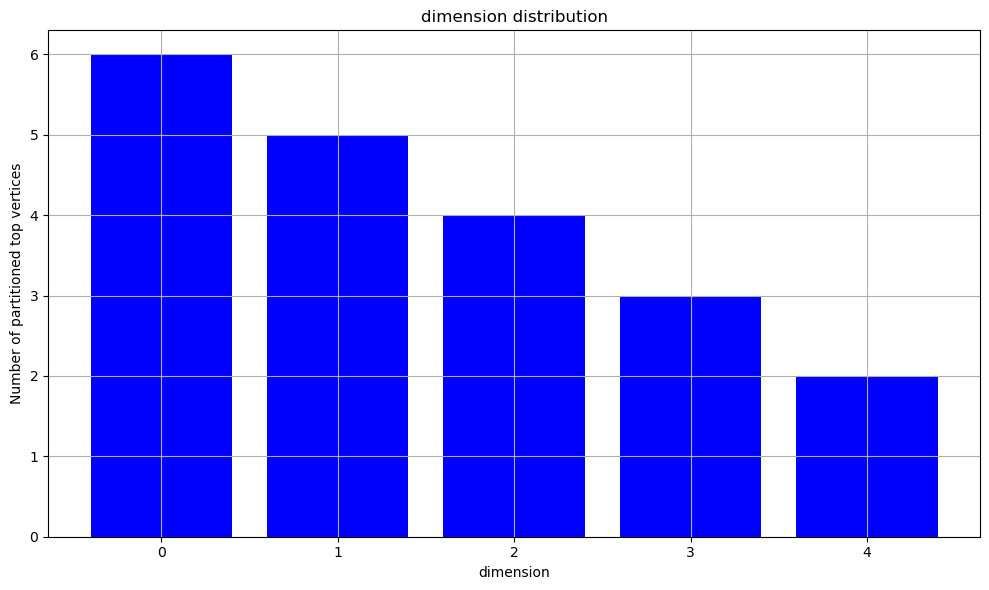

<Figure size 640x480 with 0 Axes>

In [14]:
"""Code testing"""
K_10 = dgl.heterograph({('paper', 'cites', 'paper'): (SimplexCreator(dimension=5).src, SimplexCreator(dimension=5).dst)})
filepath = 'K_10'
K_10_preprocessing = PseudoTV(filepath,graph=K_10,dimension=4)
K_10_preprocessing.inductive_connecting()
#K_10_preprocessing.load_ptv_dict()
print("Top vertices dictionary=",K_10_preprocessing.top_vertices_dictionary)
print("Partition by dimension=",K_10_preprocessing.pseudo_top_vertices_dict)
print("top vertex dictionary=",K_10_preprocessing.top_vertices_dictionary)
print("Partitions before refinement=",K_10_preprocessing._partition)
K_10_preprocessing.refinement()
K_10_preprocessing.add_vertex_features()
print("Partitions after refinement=",K_10_preprocessing._partition)
print("One hot encoding of pure tv=",K_10_preprocessing.one_hot_dict)
print("multi hot encoding of all dimensions for tv=",K_10_preprocessing.multi_hot_tv_dict)
print("partition indices=",K_10_preprocessing.partition_index)
print("tv + partition index hot dict=",K_10_preprocessing.partition_indices_and_one_hot_tv)
print("partitioned one-hot encoding, with index 1 if vertex is refined ith time=",K_10_preprocessing.partitioned_tv)
print("index of partitions=",K_10_preprocessing.partition_times_hot_dict)
#K_10_preprocessing.make_plots('partitioned_tv')
K_10_preprocessing.make_plots('tv')

In [ ]:
"""Code testing"""
src_bell = [0,0,0,1,1,2] + [1] + [4,4,4,5,5,6]
dst_bell = [1,2,3,2,3,3] + [4] + [5,6,7,6,7,7]
bell = dgl.heterograph({('paper', 'cites', 'paper'): (src_bell, dst_bell)})
filepath = 'bell'
bell_preprocessing = PseudoTV(filepath,graph=bell,dimension=30)
bell_preprocessing.inductive_connecting()
print("Top vertices dictionary=",bell_preprocessing.top_vertices_dictionary)
print("Partition by dimension=",bell_preprocessing.pseudo_top_vertices_dict)
print("top vertex dictionary=",bell_preprocessing.top_vertices_dictionary)
print("Partitions before refinement=",bell_preprocessing._partition)
bell_preprocessing.refinement()
bell_preprocessing.add_vertex_features()
print("Partitions after refinement=",bell_preprocessing._partition)
print("One hot encoding of pure tv=",bell_preprocessing.one_hot_dict)
print("multi hot encoding of all dimensions for tv=",bell_preprocessing.multi_hot_tv_dict)
print("partition indices=",bell_preprocessing.partition_index)
print("tv + partition index hot dict=",bell_preprocessing.partition_indices_and_one_hot_tv)
print("partitioned one-hot encoding, with index 1 if vertex is refined ith time=",bell_preprocessing.partitioned_tv)
print("index of partitions=",bell_preprocessing.partition_times_hot_dict)
#bell_preprocessing.save_dicts()

In [ ]:
import random
def generate_random_graph(num_nodes):
    src_edges =[]
    dst_edges = []
    edges = []
    for i in range(2*num_nodes):
        src_edges.append(random.randint(0,num_nodes))
        dst_edges.append(random.randint(0,num_nodes))
        edges.append((src_edges[i],dst_edges[i]))
    graph = dgl.heterograph({('paper', 'cites', 'paper'): (src_edges, dst_edges)})
    return graph, edges

In [ ]:
#Just to visualize the random graph.

import matplotlib.pyplot as plt
import networkx as nx

dgl_G, edges = generate_random_graph(30)
print(edges)
nx_G = nx.DiGraph()
nx_G.add_edges_from(edges)
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
pos = nx.spring_layout(nx_G, seed=42)
pos = nx.planar_layout(nx_G)
nx.draw_networkx(nx_G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10, font_color='black', arrows=True)
plt.show()

In [ ]:
filepath='randomgraph'
random_graph_preprocessing = PseudoTV(filepath,graph=dgl_G,dimension=30)
random_graph_preprocessing.inductive_connecting()
print("Top vertices dictionary=",random_graph_preprocessing.top_vertices_dictionary)
print("Partition by dimension=",random_graph_preprocessing.pseudo_top_vertices_dict)
print("top vertex dictionary=",random_graph_preprocessing.top_vertices_dictionary)
print("Partitions before refinement=",random_graph_preprocessing._partition)
random_graph_preprocessing.refinement()
random_graph_preprocessing.add_vertex_features()
print("Partitions after refinement=",random_graph_preprocessing._partition)
print("One hot encoding of pure tv=",random_graph_preprocessing.one_hot_dict)
print("multi hot encoding of all dimensions for tv=",random_graph_preprocessing.multi_hot_tv_dict)
print("partition indices=",random_graph_preprocessing.partition_index)
print("tv + partition index hot dict=",random_graph_preprocessing.partition_indices_and_one_hot_tv)
print("partitioned one-hot encoding, with index 1 if vertex is refined ith time=",random_graph_preprocessing.partitioned_tv)
print("index of partitions=",random_graph_preprocessing.partition_times_hot_dict)
#random_graph_preprocessing.save_dicts()

Using the graph convolution network architecture

In [ ]:
class GCN(nn.Module):
    def __init__(self, graph, input_layer:int, hidden_layers:int, output_layer:int, 
                 num_layers:int, dropout):
        """
        Defines the architecture of your model.  All layers with learnable parameters should
        be created in this method.  The `forward` method will define how to use the 
        layers created here.
        
        You will also need to add arguments to the `__init__` method that you need to 
        create your layers.  For example, you might want to include a `num_layers` argument
        so that you can dynamically change the number of layers, and a `dropout` argument 
        so that this is easy to change.
        """
        self.input_layer   = input_layer
        self.hidden_layers = hidden_layers
        self.output_layer  = output_layer
        self.num_layers    = num_layers
        self.dropout       = dropout
        self.graph         = graph
        super(GCN, self).__init__()
        self.convs         = nn.ModuleList()
        self.bns           = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_layers))
        self.convs.append(GraphConv(input_layer, hidden_layers, norm='both', weight=True, bias=True))
        
        for _ in range(num_layers - 2):
            self.convs.append(GraphConv(hidden_layers, hidden_layers,
                                           norm='both', weight=True, bias=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_layers))
        self.convs.append(GraphConv(hidden_layers, output_layer, 
                                    norm='both', weight=True, bias=True))

    def forward(self, graph, input_features):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        # Stack of model components to compute the forward pass 
        for conv in self.convs[:-1]:
            input_features = conv(graph, input_features)
            input_features = F.relu(input_features)
            input_features = F.dropout(input_features, p=self.dropout, training=self.training)
        input_features = self.convs[-1](graph, input_features)
        return input_features.log_softmax(dim=-1)
    
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

In [ ]:
"""Helper Functions"""

def plot_losses(train_losses, val_losses, modelname, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()
    timestamp = time.strftime("%Y%m%d%H%M%S")
    filename = f"plot_losses_{timestamp,modelname}.png"
    picklename_t = f"train_losses_{timestamp,modelname}.pkl"
    picklename_l = f"train_losses_{timestamp,modelname}.pkl"
    plt.savefig(filename)
    
    with open(picklename_t, 'wb') as file:
        pickle.dump(train_losses, file)
    
    with open(picklename_l, 'wb') as file:
        pickle.dump(val_losses, file)
        
    
def train(graph, labels, split_idx, model, epochs, evaluator, 
          device, save_path, loss_fn=F.cross_entropy, lr=0.01, es_criteria=5, verbose=False):
    """
    A standard interface for model training.  Should be no reason to change this unless you 
    want to add improvements (e.g., learning rate scheduler).
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0
    train_losses = list()
    val_losses = list()

    features = graph.ndata['feat']
    
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    test_mask = split_idx['test'].to(device)
    es_iters = 0

    for e in range(1, epochs+1):
        
        train_loss, val_loss = train_step(
            model, graph, features, labels, train_mask, val_mask, optimizer, loss_fn
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        train_acc, val_acc, test_acc = test(model, graph, labels, split_idx, evaluator)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            torch.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1
            

        if e % 50 == 0 and verbose:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_acc, best_val_acc, test_acc, best_test_acc))
            
        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break
            
    return np.array(train_losses), np.array(val_losses)

def train_step(model, graph, features, labels, train_mask, val_mask, optimizer, loss_fn):
    """
    A single training step
    """
    model.train()

    optimizer.zero_grad()
    logits = model(graph, features)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        val_loss = loss_fn(logits[val_mask], labels[val_mask])

    return loss.item(), val_loss.item()

@torch.no_grad()
def test(model_cp, graph, labels, split_idx, evaluator, best_path=None):
#def test(model, graph, labels, split_idx, evaluator, best_path=None):
    """
    Executes the OGB Evaluator to return accuracy for 
    the train, valid and test sets.  If passed in a model file path, 
    loads the parameters from that file, otherwise uses the model object
    passed in.
    """
    model = deepcopy(model_cp)
    
    if best_path is not None:
        model.load_state_dict(torch.load(best_path))
        
    model.eval()
    
    features = graph.ndata['feat']
    logits = model(graph, features)
    y_pred = logits.argmax(1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': labels[split_idx['train']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': labels[split_idx['valid']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': labels[split_idx['test']].reshape((-1,1)),
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

def characterize_performance(model, graph, labels, split_idx, evaluator, best_path, verbose=False):
    """
    Gets performance and compares to the Leaderboard performance for GCN.
    Optionally (`verbose=True`) will put the performance in context with the variation
    reported on the Leaderboard and indicate whether performance is above/below 
    1-standard deviation from the mean, as given by Leaderboard.
    """
    train_acc, val_acc, test_acc = test(model, graph, labels, split_idx, evaluator, best_path)
    print(
        f"Leaderboard:  Test Acc={test_acc_lb} +/- {test_acc_lb_var}, Val Acc={val_acc_lb} +/- {val_acc_lb_var}\n"
        f"Yours:        Test Acc={test_acc:.4f},            Val Acc={val_acc:.4f}\n"
    )

    val_lb = val_acc_lb - val_acc_lb_var
    val_ub = val_acc_lb + val_acc_lb_var
    
    if verbose:
        if not val_acc >= val_lb:
            print(
                f"Validation performance is worse than LB.  Expected lower bound of {val_lb:.4f}, but got {val_acc:.4f}.")
        elif val_acc > val_ub:
            print(
                f"Validation performance is better than LB.  Expected upper bound of {val_ub:.4f}, but got {val_acc:.4f}.")
        else: 
            print(
                f"Validation performance is in the expected range of {val_lb} - {val_ub}."
            )
    
    test_lb = test_acc_lb - test_acc_lb_var
    test_ub = test_acc_lb + test_acc_lb_var
    if verbose:
        if not test_acc >= test_lb:
            print(
                f"Test performance is worse than LB.  Expected lower bound of {test_lb:.4f}, but got {test_acc:.4f}.")

        elif test_acc > test_ub:
            print(
                f"Test performance is better than LB.  Expected upper bound of {test_ub:.4f}, but got {test_acc:.4f}.")
        else:
            print(f"Test performance is in the expected range of {test_lb} - {test_ub}.")
        
    return val_acc, test_acc

def norm_plot(curves, title):
    """
    Plots normal distribution curves
    curves: list of tuples like: (mu, sigma, label)
    """
    fig, ax = plt.subplots()
    for mu, sigma, label in curves:
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    
    ax.set_title(title)
    ax.legend()
    timestamp = time.strftime("%Y%m%d%H%M%S")
    filename = f"norm_plot_{timestamp}.png"
    plt.savefig(filename)
    
def get_experiment_stats(model_cls, model_args, train_args, n_experiments=10):
    """
    Runs an experiment multiple times to get a measure of variation
    """
    results = dict()
    for i in range(n_experiments):
        model = model_cls(**model_args).to(train_args['device'])
        print(f"Starting training for experiment {i+1}")
        # Add experiment number to model save_path
        train_args_cp = deepcopy(train_args)
        save_path, file_ext = train_args_cp.pop('save_path').split('.')
        timestamp = time.strftime("%Y%m%d%H%M%S")
        save_path_mod = f"{save_path}__{timestamp}_{i}.{file_ext}"
        
        train_losses, val_losses = train(model=model, save_path=save_path_mod, **train_args_cp)
        val_acc, test_acc = characterize_performance(
            model, train_args['g_simple'], train_args['labels'], train_args['split_idx'], 
            train_args['evaluator'], save_path_mod, train_args.get('verbose', False))
        
        results[i] = dict(val_acc=val_acc, test_acc=test_acc)
        print("Training complete\n")
        
    df_stats = pd.DataFrame(results).T.agg(['mean', 'std'])
    return df_stats

Load and pre-process the arxiv graph

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
dataset = DglNodePropPredDataset(name = "ogbn-arxiv", root = 'dataset/')
arxiv_graph_raw = dataset.graph[0]
#arxiv_preprocessing.load_ptv_dict('semi_tv_upto5.json')
split_idx = dataset.get_idx_split()
labels = dataset.labels.flatten().to(device)
#performance of of vanilla GCN
val_acc_lb, val_acc_lb_var, test_acc_lb, test_acc_lb_var = 0.7300, 0.0017, 0.7174, 0.0029
evaluator = Evaluator(name = "ogbn-arxiv")

In [7]:
file_name = "arxiv_semi_tv_upto5.json"
arxiv_preprocessing_d5 = PseudoTV(file_name,graph=arxiv_graph_raw,dimension=5)
arxiv_preprocessing.load_ptv_dict()
arxiv_preprocessing_d5.inductive_connecting()
arxiv_preprocessing_d5.refinement()
print("Creating vertex features for the graph now")
arxiv_preprocessing_d5.add_vertex_features()
arxiv_preprocessing_d5.save_dicts()
#arxiv_preprocessing_d5.load_dicts()

Finished adding 0-top vertices and 1-top vertices in main dictionary
Finished adding 0-pseudo top vertices and 1-pseudo top vertices
Creating vertex features for the graph now


Create the graphs with different feature vectors

In [9]:
def add_features_to_graph(graph,features):
    """All the existing features and new features need to be stacked and then replaced
    with existing features. DGL graph library doesn't support adding node features node-wise
    Returns the graph"""
    if not "feat" in graph.ndata:
        print("Error! The graph should have node features called 'feat'.")
        return
    else:
        existing_node_features = graph.ndata['feat']
    
    if not (type(features) == dict or type(features) == collections.defaultdict):
        print("Error! Features should be a dictionary")
        return
    stacked_features = torch.stack(list(features.values()))
    # Iterate through nodes and concatenate stacked_features to existing_node_features
    concatenated_features = []
    for node_id in graph.nodes():
        concatenated_feature = torch.cat((existing_node_features[node_id], stacked_features[node_id]), dim=0)
        concatenated_features.append(concatenated_feature)

    concatenated_features = torch.stack(concatenated_features, dim=0)

    graph.ndata['feat'] = concatenated_features
    
    return graph

print("Creating six different graphs..")
arxiv_graph_bidirected = dgl.to_bidirected(arxiv_graph_raw)
arxiv_graph_bidirected = dgl.add_self_loop(arxiv_graph_raw)
#once a graph is converted, it loses node features, so they have to be added again
arxiv_graph_bidirected.ndata['feat'] = arxiv_graph_raw.ndata['feat']

arxiv_graph = dgl.add_self_loop(arxiv_graph_raw)
arxiv_graph.ndata['feat'] = arxiv_graph_raw.ndata['feat']

#add features to nodes of undirected graphs. 
arxiv_graph_bidirected_mixed_tv_d5 = add_features_to_graph(
    arxiv_graph_bidirected,arxiv_preprocessing_d5.multi_hot_tv_dict)
arxiv_graph_bidirected_tv_and_pi_d5 = add_features_to_graph(
    arxiv_graph_bidirected,arxiv_preprocessing_d5.partition_indices_and_one_hot_tv)
arxiv_graph_bidirected_refined_d5 = add_features_to_graph(
    arxiv_graph_bidirected,arxiv_preprocessing_d5.partitioned_tv)

#add features to nodes of directed graphs
arxiv_graph_mixed_tv_d5 = add_features_to_graph(
    arxiv_graph,arxiv_preprocessing_d5.multi_hot_tv_dict)
arxiv_graph_tv_and_pi_d5 = add_features_to_graph(
    arxiv_graph,arxiv_preprocessing_d5.partition_indices_and_one_hot_tv)
arxiv_graph_refined_d5 = add_features_to_graph(
    arxiv_graph,arxiv_preprocessing_d5.partitioned_tv)

#the 'year' data is added to all graphs.
arxiv_graph_bidirected_mixed_tv_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_bidirected_tv_and_pi_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_bidirected_refined_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_mixed_tv_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_tv_and_pi_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_refined_d5.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph.ndata['year'] = arxiv_graph_raw.ndata['year']
arxiv_graph_bidirected.ndata['year'] = arxiv_graph_raw.ndata['year']
print("Graphs made")

Creating six different graphs..
Graphs made


Create models here

In [ ]:
def getdim_inlayer(graph):
    """The dimensions of each node features is different, so 
    a function here is needed that can yield the dimension of the input layer"""
    return graph.ndata['feat'].size()[1]

model1_mixedtv_kwargs_d5 = dict(graph=arxiv_graph_mixed_tv_d5, 
                                input_layer=getdim_inlayer(arxiv_graph_mixed_tv_d5), 
                                hidden_layers=256, output_layer=40, 
                                num_layers=3, dropout=0.5)

model1_mixedtv_d5 = GCN(**model1_mixedtv_kwargs_d5).to(device)

model1_tv_and_pi_kwargs_d5 = dict(graph=arxiv_graph_tv_and_pi_d5, 
                                  input_layer=getdim_inlayer(arxiv_graph_tv_and_pi_d5), 
                                  hidden_layers=256, output_layer=40, 
                                  num_layers=3, dropout=0.5)

model1_tv_and_pi_d5 = GCN(**model1_tv_and_pi_kwargs_d5).to(device)

model1_refined_tv_kwargs_d5 = dict(graph=arxiv_graph_refined_d5, 
                                   input_layer=getdim_inlayer(arxiv_graph_refined_d5),
                                   hidden_layers=256, output_layer=40, 
                                   num_layers=3, dropout=0.5)

model1_refined_tv_d5 = GCN(**model1_refined_tv_kwargs_d5).to(device)

model1_baseline_kwargs_d5 = dict(graph=arxiv_graph, 
                                   input_layer=getdim_inlayer(arxiv_graph),
                                   hidden_layers=256, output_layer=40, 
                                   num_layers=3, dropout=0.5)

model1_baseline_d5 = GCN(**model1_baseline_kwargs_d5).to(device)

model2_mixedtv_kwargs_d5 = dict(graph=arxiv_graph_bidirected_mixed_tv_d5, 
                                input_layer=getdim_inlayer(arxiv_graph_bidirected_mixed_tv_d5), 
                                hidden_layers=256, output_layer=40, 
                                num_layers=3, dropout=0.5)

model2_mixedtv_d5 = GCN(**model2_mixedtv_kwargs_d5).to(device)

model2_tv_and_pi_kwargs_d5 = dict(graph=arxiv_graph_bidirected_tv_and_pi_d5, 
                                  input_layer=getdim_inlayer(arxiv_graph_bidirected_tv_and_pi_d5), 
                                  hidden_layers=256, output_layer=40, 
                                  num_layers=3, dropout=0.5)

model2_tv_and_pi_d5 = GCN(**model2_tv_and_pi_kwargs_d5).to(device)

model2_refined_tv_kwargs_d5 = dict(graph=arxiv_graph_bidirected_refined_d5, 
                                   input_layer=getdim_inlayer(arxiv_graph_bidirected_refined_d5),
                                   hidden_layers=256, output_layer=40, 
                                   num_layers=3, dropout=0.5)

model2_refined_tv_d5 = GCN(**model2_refined_tv_kwargs_d5).to(device)

model2_baseline_kwargs_d5 = dict(graph=arxiv_graph_bidirected, 
                                   input_layer=getdim_inlayer(arxiv_graph_bidirected),
                                   hidden_layers=256, output_layer=40, 
                                   num_layers=3, dropout=0.5)

model2_baseline_d5 = GCN(**model2_baseline_kwargs_d5).to(device)


#create different paths for the models
model1_tv_and_pi_path_d5 = 'model1_tv_and_pi_d5'
Path(model1_tv_and_pi_path_d5).mkdir(parents=True, exist_ok=True)
gcn1_tv_and_pi_path_d5 = f"{model1_tv_and_pi_path_d5}/gcn_base.model"

model1_mixed_tv_path_d5 = 'model1_mixed_tv_d5'
Path(model1_mixed_tv_path_d5).mkdir(parents=True, exist_ok=True)
gcn1_mixed_tv_path_d5 = f"{model1_mixed_tv_path_d5}/gcn_base.model"

model1_refined_tv_path_d5 = 'model1_refined_tv_d5'
Path(model1_refined_tv_path_d5).mkdir(parents=True, exist_ok=True)
gcn1_refined_tv_path_d5 = f"{model1_refined_tv_path_d5}/gcn_base.model"

model1_baseline_path_d5 = 'model1_baseline_d5'
Path(model1_baseline_path_d5).mkdir(parents=True, exist_ok=True)
gcn1_baseline_path_d5 = f"{model1_baseline_path_d5}/gcn_base.model"

model2_tv_and_pi_path_d5 = 'model2_tv_and_pi_d5'
Path(model2_tv_and_pi_path_d5).mkdir(parents=True, exist_ok=True)
gcn2_tv_and_pi_path_d5 = f"{model2_tv_and_pi_path_d5}/gcn_base.model"

model2_mixed_tv_path_d5 = 'model2_mixed_tv_d5'
Path(model2_mixed_tv_path_d5).mkdir(parents=True, exist_ok=True)
gcn2_mixed_tv_path_d5 = f"{model2_mixed_tv_path_d5}/gcn_base.model"

model2_refined_tv_path_d5 = 'model2_refined_tv_d5'
Path(model2_refined_tv_path_d5).mkdir(parents=True, exist_ok=True)
gcn2_refined_tv_path_d5 = f"{model2_refined_tv_path_d5}/gcn_base.model"

model2_baseline_path_d5 = 'model2_baseline_d5'
Path(model2_baseline_path_d5).mkdir(parents=True, exist_ok=True)
gcn2_baseline_path_d5 = f"{model2_baseline_path_d5}/gcn_base.model"

#create training arguments to be put in the GCN module
train_args_1_tv_and_pi_d5 = dict(
    graph=arxiv_graph_tv_and_pi_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn1_tv_and_pi_path_d5, lr=5e-3, es_criteria=50,
)

train_args_1_mixed_tv_d5 = dict(
    graph=arxiv_graph_mixed_tv_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn1_mixed_tv_path_d5, lr=5e-3, es_criteria=50,
)

train_args_1_refined_tv_d5 = dict(
    graph=arxiv_graph_refined_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn1_refined_tv_path_d5, lr=5e-3, es_criteria=50,
)

train_args_1_baseline_d5 = dict(
    graph=arxiv_graph, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn1_baseline_path_d5, lr=5e-3, es_criteria=50,
)

train_args_2_tv_and_pi_d5 = dict(
    graph=arxiv_graph_bidirected_tv_and_pi_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn2_tv_and_pi_path_d5, lr=5e-3, es_criteria=50,
)

train_args_2_mixed_tv_d5 = dict(
    graph=arxiv_graph_bidirected_mixed_tv_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn2_mixed_tv_path_d5, lr=5e-3, es_criteria=50,
)

train_args_2_refined_tv_d5 = dict(
    graph=arxiv_graph_bidirected_refined_d5, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn2_refined_tv_path_d5, lr=5e-3, es_criteria=50,
)

train_args_2_baseline_d5 = dict(
    graph=arxiv_graph_bidirected, labels=labels, split_idx=split_idx, 
    epochs=500, evaluator=evaluator, device=device, 
    save_path=gcn2_baseline_path_d5, lr=5e-3, es_criteria=50,
)

Experimental evaluation

In [ ]:
print("Training for directed graph with mixed tv features..")
train_losses1_mixedtv_d5, val_losses1_mixedtv_d5 = train(
    model=model1_mixedtv_d5, verbose=True, **train_args_1_mixed_tv_d5)

print("Training for directed graph with tv and pi..")
train_losses1_tv_and_pi_d5, val_losses1_tv_and_pi_d5 = train(
    model=model1_tv_and_pi_d5, verbose=True, **train_args_1_tv_and_pi_d5)

print("Training for directed graph with refined tv..")
train_losses1_refined_tv_d5, val_losses1_refined_tv_d5 = train(
    model=model1_refined_tv_d5, verbose=True, **train_args_1_refined_tv_d5)

print("Training for baseline directed graph..")
train_losses1_baseline_d5, val_losses1_baseline_d5 = train(
    model=model1_baseline_d5, verbose=True, **train_args_1_baseline_d5)

print("Training for undirected graph with mixed tv..")
train_losses2_mixedtv_d5, val_losses2_mixedtv_d5 = train(
    model=model2_mixedtv_d5, verbose=True, **train_args_2_mixed_tv_d5)

print("Training for undirected graph with tv and pi..")
train_losses2_tv_and_pi_d5, val_losses2_tv_and_pi_d5 = train(
    model=model2_tv_and_pi_d5, verbose=True, **train_args_2_tv_and_pi_d5)

print("Training for undirected graph with refined tv..")
train_losses2_refined_tv_d5, val_losses2_refined_tv_d5 = train(
    model=model2_refined_tv_d5, verbose=True, **train_args_2_refined_tv_d5)

print("Training for baseline undirected graph..")
train_losses2_baseline_d5, val_losses2_baseline_d5 = train(
    model=model2_baseline_d5, verbose=True, **train_args_2_baseline_d5)

print("Creating plots..")
plot_losses(
    train_losses1_mixedtv_d5, val_losses1_mixedtv_d5, log=True, modelname='1_mixedtv_d5')
plot_losses(
    train_losses1_tv_and_pi_d5, val_losses1_tv_and_pi_d5, log=True, modelname='1_tv_and_pi_3')
plot_losses(
    train_losses1_refined_tv_d5, val_losses1_refined_tv_d5, log=True, modelname='1_refined_tv_d5')
plot_losses(
    train_losses1_baseline_d5, val_losses1_baseline_d5, log=True, modelname='1_baseline_d5')
plot_losses(
    train_losses2_mixedtv_d5, val_losses2_mixedtv_d5, log=True, modelname='2_mixedtv_d5')
plot_losses(
    train_losses2_tv_and_pi_d5, val_losses2_tv_and_pi_d5, log=True, modelname='2_tv_and_pi_3')
plot_losses(
    train_losses2_refined_tv_d5, val_losses2_refined_tv_d5, log=True, modelname='2_refined_tv_d5')
plot_losses(
    train_losses2_baseline_d5, val_losses2_baseline_d5, log=True, modelname='2_baseline_d5')

print("Characterizing performance of the model for directed graph with tv and pi")
characterize_performance(
    model1_tv_and_pi_d5, arxiv_graph_tv_and_pi_d5, labels, split_idx, evaluator, gcn1_tv_and_pi_path_d5, verbose=True)

print("Characterizing performance of the model for directed graph with mixed tv")
characterize_performance(
    model_mixedtv_d5, arxiv_graph_mixed_tv_d5, labels, split_idx, evaluator, gcn1_mixed_tv_path_d5, verbose=True)

print("Characterizing performance of the model for directed graph with refined tv")
characterize_performance(
    model1_refined_tv_d5, arxiv_graph_refined_d5, labels, split_idx, evaluator, gcn1_refined_tv_path_d5, verbose=True)

print("Characterizing performance of the baseline model for directed graph")
characterize_performance(
    model1_baseline_d5, arxiv_graph, labels, split_idx, evaluator, gcn1_baseline_path_d5, verbose=True)

print("Characterizing performance of the model for undirected graph with tv and pi")
characterize_performance(
    model2_tv_and_pi_d5, arxiv_graph_bidirected_tv_and_pi_d5, labels, split_idx, evaluator, gcn2_tv_and_pi_path_d5, verbose=True)

print("Characterizing performance of the model for directed graph with mixed tv")
characterize_performance(
    model2_mixedtv_d5, arxiv_graph_bidirected_mixed_tv_d5, labels, split_idx, evaluator, gcn2_mixed_tv_path_d5, verbose=True)

print("Characterizing performance of the model for directed graph with refined tv")
characterize_performance(
    model2_refined_tv_d5, arxiv_graph_bidirected_refined_d5, labels, split_idx, evaluator, gcn2_refined_tv_path_d5, verbose=True)

print("Characterizing performance of the baseline model for undirected graph")
characterize_performance(
    model2_baseline_d5, arxiv_graph_bidirected, labels, split_idx, evaluator, gcn2_baseline_path_d5, verbose=True)

Main training

In [ ]:
print("Beginning training with 10 experiments of the model for directed graph with mixed tv..")
df_gcn1_mixedtv_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model1_mixedtv_kwargs_d5,
    train_args=train_args_1_mixed_tv_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the model for directed graph with tv and pi")
df_gcn1_tv_and_pi_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model1_tv_and_pi_kwargs_d5,
    train_args=train_args_1_tv_and_pi_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the model for directed graph with refined tv")
df_gcn1_refined_tv_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model1_refined_tv_kwargs_d5,
    train_args=train_args_1_refined_tv_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the baseline model for directed graph")
df_gcn1_baseline_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model1_baseline_kwargs_d5,
    train_args=train_args_1_baseline_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the model for undirected graph with mixed tv")
df_gcn2_mixedtv_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model2_mixedtv_kwargs_d5,
    train_args=train_args_2_mixed_tv_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the model for directed graph with tv and pi")
df_gcn2_tv_and_pi_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model2_tv_and_pi_kwargs_d5,
    train_args=train_args_2_tv_and_pi_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the model for directed graph with refined tv")
df_gcn2_refined_tv_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model2_refined_tv_kwargs_d5,
    train_args=train_args_2_refined_tv_d5, n_experiments=10
)

print("Beginning training with 10 experiments of the baseline model for directed graph")
df_gcn2_baseline_d5 = get_experiment_stats(
    model_cls=GCN, model_args=model2_baseline_kwargs_d5,
    train_args=train_args_2_baseline_d5, n_experiments=10
)

Plot results

In [ ]:
print("Creating norm plot for directed graph with tv and pi")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn1_tv_and_pi_d5.loc['mean', 'test_acc'], df_gcn1_tv_and_pi_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for directed graph with mixed tv")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn1_mixedtv_d5.loc['mean', 'test_acc'], df_gcn1_mixedtv_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for directed graph with refined tv")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn1_refined_tv_d5.loc['mean', 'test_acc'], df_gcn1_refined_tv_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for baseline directed graph")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn1_baseline_d5.loc['mean', 'test_acc'], df_gcn1_baseline_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for undirected graph with tv and pi")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn2_tv_and_pi_d5.loc['mean', 'test_acc'], df_gcn2_tv_and_pi_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for undirected graph with mixed tv")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn2_mixedtv_d5.loc['mean', 'test_acc'], df_gcn2_mixedtv_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for undirected graph with refined tv")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn2_refined_tv_d5.loc['mean', 'test_acc'], df_gcn2_refined_tv_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)
print("Creating norm plot for baseline undirected graph")
norm_plot(
    [
        (test_acc_lb, test_acc_lb_var, 'Leaderboard'), 
        (df_gcn2_baseline_d5.loc['mean', 'test_acc'], df_gcn2_baseline_d5.loc['std', 'test_acc'], 'GCN'),
    ],
    'Test Performance'
)


print("Evaluating the model for directed graph with refined tv")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn1_refined_tv_d5.loc['mean', 'test_acc'], df_gcn1_refined_tv_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn1_refined_tv_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for directed graph with mixed tv")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn1_mixedtv_d5.loc['mean', 'test_acc'], df_gcn1_mixedtv_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn1_mixedtv_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for directed graph with tv and pi")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn1_tv_and_pi_d5.loc['mean', 'test_acc'], df_gcn1_tv_and_pi_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn1_tv_and_pi_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for baseline directed graph")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn1_baseline_d5.loc['mean', 'test_acc'], df_gcn1_baseline_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn1_baseline_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for undirected graph with refined tv")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn2_refined_tv_d5.loc['mean', 'test_acc'], df_gcn2_refined_tv_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn2_refined_tv_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for undirected graph with mixed tv")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn2_mixedtv_d5.loc['mean', 'test_acc'], df_gcn2_mixedtv_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn2_mixedtv_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for undirected graph with tv and pi")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn2_tv_and_pi_d5.loc['mean', 'test_acc'], df_gcn2_tv_and_pi_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn2_tv_and_pi_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")

print("Evaluating the model for baseline undirected graph")
_, p = stats.ttest_ind_from_stats(
    test_acc_lb, test_acc_lb_var, 10,
    df_gcn2_baseline_d5.loc['mean', 'test_acc'], df_gcn2_baseline_d5.loc['std', 'test_acc'], 10,
    equal_var=False,
)
print(f"Mean Test Accuracy Improvement: {(df_gcn2_baseline_d5.loc['mean', 'test_acc'] - test_acc_lb):.4f}")
print(f"Probability that these are from the same performance distribution = {p*100:.0f}%")